In [1]:
import numpy as np
import json
import os

def position_matrix(trial : int, joint: str):
    """ 
    return the position matrix of a joint for a trial.
    precondition : 0 < trial < 126
    """
    data_directory = '../basketball/freethrow/data/P0001/'
    data_files = sorted(os.listdir(data_directory))
    trial_data = f'../basketball/freethrow/data/P0001/{data_files[trial - 1]}'

    with open(trial_data, 'r') as file:
        data = json.load(file)
    
    matrix = np.empty((0, 3))
    for i in range(len(data['tracking'])):
        row = np.array(data['tracking'][i]['data']['player'][joint])
        matrix = np.vstack([matrix, row])
    return matrix

In [2]:
def initial_position_vector(trial: int, joint: str):
    """ 
    returns the initial position vector of a joint for a trial.
    """
    matrix = position_matrix(trial, joint)
    return matrix[0]

In [3]:
def vector_relationship(P0, P1):
    """
    checks if vectors P0 and P1 are parallel, anti-parallel, or neither. 
    """
    if np.allclose(P0, P1):
        return "parallel"
    elif np.allclose(np.cross(P0, P1), [0, 0, 0]):
        return "anti-parallel"
    else:
        return "neither"

In [4]:
import math
from pyquaternion import Quaternion

def quaternion(P0, P1): 
    """
    takes position vectors and returns a quartnion representation of rotation
    from position vector P0 to P1. 
    """
    unit_P0 = P0 / np.linalg.norm(P0)
    unit_P1 = P1 / np.linalg.norm(P1)
    
    relation = vector_relationship(unit_P0, unit_P1)

    if relation == "parallel":
        return Quaternion()

    elif relation == "anti-parallel":
        if np.allclose(unit_P0, [1, 0, 0]):
            axis_of_rotation = [0, 1, 0]
        else:
            cross_product = np.cross(unit_P0, [1, 0, 0])
            axis_of_rotation = cross_product / np.linalg.norm(cross_product)
        return Quaternion(axis=axis_of_rotation, radians=math.pi)

    else:
        cross_product = np.cross(unit_P0, unit_P1)
        magnitude = np.linalg.norm(cross_product)
        axis_of_rotation = cross_product / magnitude

        theta = np.arccos(np.dot(unit_P0, unit_P1))
        return Quaternion(axis = axis_of_rotation, radians=theta)

In [8]:
def sequence_quaternions(position_matrix):
    """
    parameters : 

    position_matrix : a 2D numpy array where each row is the 3D position vector
    for each time stamp. 

    sequence_quaternions computes a sequence of quaternions to represent
    the relative rotation of a joint through time.

    returns a numpy array of quaternions ordered by time stamp. 
    """
    quaternions = []

    for i in range(1, len(position_matrix)):
        P0 = position_matrix[i - 1]
        P1 = position_matrix[i]

        quaternions.append(quaternion(P0, P1))
    return np.array(quaternions)

In [10]:
shoulder_data = position_matrix(1, 'R_SHOULDER')
sequence_quaternions(shoulder_data)

array([Quaternion(0.9999999998010117, 3.4732324195902096e-06, 3.4732324195928113e-06, -1.933519871223502e-05),
       Quaternion(0.9999999995625779, 2.865846500173135e-06, 2.219977951617482e-05, -1.933393301599518e-05),
       Quaternion(0.9999999997532466, -6.063960146018986e-07, 2.2198451471060074e-05, -6.063960146027661e-07),
       Quaternion(0.9999999996452074, 2.8648847368633747e-06, 1.8726687632322946e-05, -1.872668763231774e-05),
       Quaternion(0.9999999998244669, -6.056653695544724e-07, 1.872696988572767e-05, -1.7347234497342937e-18),
       Quaternion(0.9999999999937961, 4.3368083374920857e-19, -3.4700208890498247e-06, 6.056922188041083e-07),
       Quaternion(0.9999999998010517, -3.4702769979965126e-06, -3.4702769980025837e-06, 1.9334192902191577e-05),
       Quaternion(1.0, 0.0, 0.0, 0.0),
       Quaternion(0.9999999998010228, -3.470528259362923e-06, -3.4705282593698614e-06, 1.9335592771924564e-05),
       Quaternion(0.9999999998185892, -3.470650163995025e-06, 0.0, 1.872

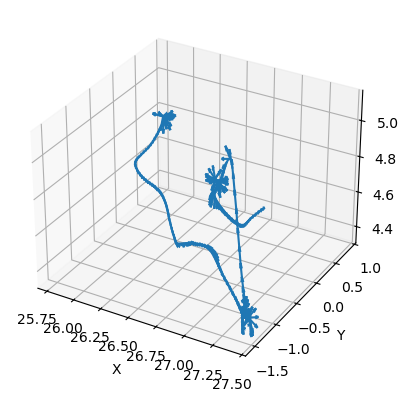

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = shoulder_data[:, 0]
y = shoulder_data[:, 1]
z = shoulder_data[:, 2]

u = x[1:] - x[:-1]  
v = y[1:] - y[:-1]  
w = z[1:] - z[:-1] 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(x[:-1], y[:-1], z[:-1], u, v, w, length=0.1, normalize=True)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()
